In [1]:
from collections import namedtuple
import gym
from scipy.special import softmax as sci_softmax
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
import pickle

In [2]:
# Setup environment
env = gym.make('CartPole-v1')



help(env.unwrapped)

Help on CartPoleEnv in module gym.envs.classic_control.cartpole object:

class CartPoleEnv(gym.core.Env)
 |  Description:
 |      A pole is attached by an un-actuated joint to a cart, which moves along
 |      a frictionless track. The pendulum starts upright, and the goal is to
 |      prevent it from falling over by increasing and reducing the cart's
 |      velocity.
 |  
 |  Source:
 |      This environment corresponds to the version of the cart-pole problem
 |      described by Barto, Sutton, and Anderson
 |  
 |  Observation:
 |      Type: Box(4)
 |      Num     Observation               Min                     Max
 |      0       Cart Position             -4.8                    4.8
 |      1       Cart Velocity             -Inf                    Inf
 |      2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
 |      3       Pole Angular Velocity     -Inf                    Inf
 |  
 |  Actions:
 |      Type: Discrete(2)
 |      Num   Action
 |      0  

In [3]:
# Activation Function of the output Layer
def softmax_act(arr):
    e_z = np.exp(arr - np.max(arr, axis=-1, keepdims=True))
    activated = e_z / np.sum(e_z, axis=-1, keepdims=True)
    return activated
#Derivative of the softmax function
def softmax_derv(activ_out):
    grad_soft = activ_out * (1 - activ_out)
    return grad_soft
# Cross entropy Loss function
def cross_entropy(predict,label):
    sample = predict.shape[0]
    prediction = np.clip(predict, 1e-15, 1 - 1e-15)
    cost = np.sum(-label * np.log(prediction) - (1 - label) * np.log(1 -prediction))
    cr_out = cost/sample
    return cr_out
# Derivative of the Loss function
def cross_derv(predict,label):
    predictions = np.clip(predict, 1e-15, 1 - 1e-15)
    der_ce = - (label/predictions) + (1 - label) / (1 - predictions)
    return der_ce

def sigmoid(z_out):
    out_act = 1/(1+np.exp(-z_out))
    
    return out_act
    
    
def sigmoid_derv(activ_out):
    
    out_der = activ_out * (1-activ_out)
    
    return out_der

def relu(z):
    
    a_re = np.where(z>=0,z,0)
    
    return a_re
    
    
def relu_grad(a_rel):
    
    
    da_re = np.where(a_rel >0,1,0)
    
    
    return da_re
    

def Tanh(activ):

    t_out = np.tanh(activ)
    
    return t_our

def Tanh_grad(activ_out):
    
    t_grad = 1 - np.square(activ_out)
    
    return t_grad

In [4]:
def q_val(observ,w_1,w_2):


    z_1 = np.dot(observ, w_1)

    a_1 = relu(z_1)

    #a1_list.append(a_1)

    z_2 = np.dot(a_1, w_2)
    a_2 = z_2
    #a2_list.append(a_2)

    act_samp = np.argmax(a_2)
    act_arr = act_samp
    
    
    return a_1, a_2

In [5]:
def replay(rep, batch,w_1,w_2):
    
    gamma = 0.99
    minibatch = np.random.choice(rep, batch, replace=True)
    s_l =      np.array(list(map(lambda x: x['s'], minibatch)))
    a_l =      np.array(list(map(lambda x: x['a'], minibatch)))
    r_l =      np.array(list(map(lambda x: x['r'], minibatch)))
    sprime_l = np.array(list(map(lambda x: x['sprime'], minibatch)))
    done_l   = np.array(list(map(lambda x: x['done'], minibatch)))
    h_next,qvals_sprime_l = q_val(sprime_l.reshape(batch,4),w_1,w_2)
    h_target,target_f = q_val(s_l.reshape(batch,4),w_1,w_2)
    
    rewards_l = r_l.reshape(batch,1)
    actions_l = a_l.reshape(batch,1)
    
    # q-update
    for k in range(batch):
        done_flag = done_l[k]
        if not done_flag:
            
            target = rewards_l[k] + gamma * np.max(qvals_sprime_l[k,:], axis=0)
            act_taken = actions_l[k]
            
            target_f[k][act_taken] = target
        else:
            act_taken = actions_l[k]
            target_f[k][act_taken] = rewards_l[k]
            
    
    return target_f,h_next,h_target,s_l

In [55]:
EPISODES = 4000
lrn_rate = 0.03
# Weight Initialization
np.random.seed(12)
w_1 = np.random.rand(4, 4) / np.sqrt(4)
w_2 = np.random.rand(4, 2) / np.sqrt(4)


MAX_MEMORY_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.99




In [56]:
# Keep track of episodic and cumulative rewards
rewards_episodic = []
rewards_cumulative = []
memo = []
c_score = 0
count = 1
up_c = 0
epsilon = 0.9
len_ = np.zeros(EPISODES)
reward_ = np.zeros(EPISODES)
# Main loop
for e in range(EPISODES):

    obs = env.reset()[None, :]

    # Gradients list for backpropagation 

    dlog_list = []
    da_list = []
    e_rewards = []
    obs_list = []


    a2_list = []
    a1_list = []
    # reset score every episode
    e_score = 0
    ep_i = 0
    done = False
    while not done:
        
        
        if random.random() < epsilon:
            
            act_arr = env.action_space.sample()
            
        else:
                # Forward the observation through policy network
            z_1 = np.dot(obs, w_1)

            a_1 = relu(z_1)

            #a1_list.append(a_1)

            z_2 = np.dot(a_1, w_2)
            a_2 = z_2
            #a2_list.append(a_2)
            
            act_samp = np.argmax(a_2)
            act_arr = act_samp
            
            count +=1

        
        sample_action = act_arr

        # Step through environment with the sample action
        obs_next, reward, done, _ = env.step(sample_action)
        obs_next = obs_next[None, :]
      
        
        #obs_list.append(obs)

        
        
        e_rewards.append(reward)

        e_score += reward
        c_score += reward
        #memory.push_exp(Experience(obs, sample_action, reward, obs_next))

        if len(memo) > MAX_MEMORY_SIZE:
            
            memo.pop(0)

        memo.append({"s":obs,"a":sample_action,"r":reward,"sprime":obs_next,"done":done})

        # Set new observation as current 
        obs = obs_next
        
        ep_i +=1
        
        if e % BATCH_SIZE == 0:

            trg,a_next,a_trg,obs_c = replay(memo,BATCH_SIZE,w_1,w_2)

            a_hat,Q_hat = q_val(obs_c.reshape(BATCH_SIZE,-1),w_1,w_2)



            dA2 = trg - Q_hat

            dZ2 = Q_hat * dA2

            dW2 = np.dot(a_hat.T,dZ2)

            w2_up = lrn_rate * dW2 

            w_2 -= w2_up

            dA1 = np.dot(dZ2, w_2.T)

            dZ1 = dA1 * relu_grad(a_hat)
            obs_k = obs_c.reshape(BATCH_SIZE,4)
            dW1 = np.dot(obs_k.T,dZ1)

            w1_up = lrn_rate * dW1 

            w_1 -= w1_up


        
    if epsilon>0.1:
        epsilon -=0.001
    # Display Performance metrics of the episode 
    
    len_[e] = ep_i
    reward_[e] = np.mean(len_[:e])
    
    rewards_episodic.append(e_score)
    rewards_cumulative.append(c_score)
    print("Episode: " + str(e) + " Score: " + str(e_score) + "         ", end="\r", flush=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
epsilon

0.09999999999999931

## Screen Record LOOP

In [61]:
# Keep track of episodic and cumulative rewards

# Main loop
for e in range(20):

    obs = env.reset()[None, :]

    # reset score every episode
    e_score = 0
    ep_i = 0

    while True:
        
        env.render()
        
            # Forward the observation through policy network
        z_1 = np.dot(obs, w_1)

        a_1 = relu(z_1)

        #a1_list.append(a_1)

        z_2 = np.dot(a_1, w_2)
        a_2 = z_2
        #a2_list.append(a_2)

        act_samp = np.argmax(a_2)
        act_arr = act_samp



        
        sample_action = act_arr

        # Step through environment with the sample action
        obs_next, reward, done, _ = env.step(sample_action)
        obs_next = obs_next[None, :]
      
        
        #obs_list.append(obs)

        
        
        

        e_score += reward
        c_score += reward


        # Set new observation as current 
        obs = obs_next
        
        if done:
            break



        

    # Display Performance metrics of the episode Deep Q-network

    print("Episode: " + str(e + 4000) + " Score: " + str(e_score) + "         ", end="\r", flush=False)

## Visual SMA

In [57]:
r_dict = {}
r_dict['Cumulative_Average_Reward'] = reward_
r_dict['Survival_Length'] = len_


log_df = pd.DataFrame.from_dict(r_dict)
sma100 = log_df.Survival_Length.rolling(window=100).mean().to_numpy()

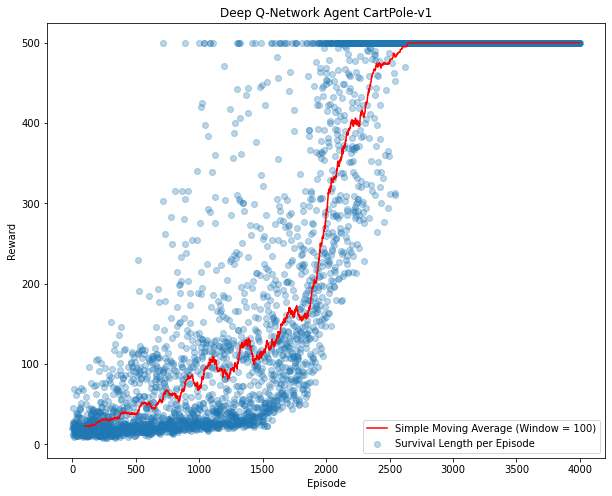

In [58]:
plt.figure(figsize=(10, 8))
plt.scatter(np.arange(log_df.shape[0]), log_df.Survival_Length, alpha=.3)
plt.plot(np.arange(log_df.shape[0]), sma100, color='r')
plt.title('Deep Q-Network Agent CartPole-v1')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Simple Moving Average (Window = 100)', 'Survival Length per Episode'], loc=4)
plt.savefig('SMA_Deep_DQN.jpg',bbox_inches='tight')
plt.show(block=False)



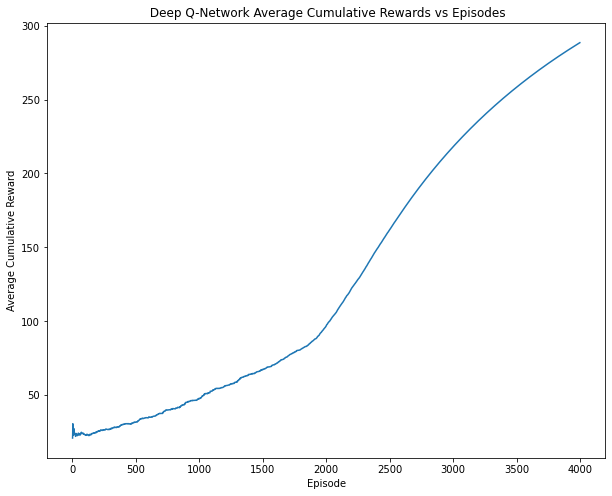

In [59]:

plt.figure(figsize=(10, 8))
plt.title(' Deep Q-Network Average Cumulative Rewards vs Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Cumulative Reward')
plt.plot(np.arange(EPISODES), reward_)
plt.savefig('AvrgCum_Deep_QN.jpg',bbox_inches='tight')
#plt.savefig('2_Deep_PolicyGradient.jpg',bbox_inches='tight')
#plt.savefig('H=64|PG_cum_avrg.png')
plt.show()

